In [2]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 106 kB 10.4 MB/s eta 0:00:01


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
from torchvision import datasets, transforms
import math
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

class SubCenterArcFaceLoss(losses.ArcFaceLoss):
    """
    Implementation of https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123560715.pdf
    """

    def __init__(self, *args, margin=28.6, scale=64, sub_centers=3, **kwargs):
        num_classes, embedding_size = kwargs['num_classes'], kwargs['embedding_size']
        super().__init__(num_classes * sub_centers, embedding_size, margin=margin, scale=scale)
        self.sub_centers = sub_centers
        self.num_classes = num_classes

    def get_cosine(self, embeddings):
        cosine = self.distance(embeddings, self.W.t())
        cosine = cosine.view(-1, self.num_classes, self.sub_centers)
        cosine, _ = cosine.max(axis=2)
        return cosine

    def get_outliers(self, embeddings, labels, threshold=75, return_dominant_centers=True, normalize=True):
        self.eval()
        if len(labels.shape) > 1:
            labels = labels.flatten()
        if normalize:
            embeddings = F.normalize(embeddings, p=2, dim=1)
        dtype, device = embeddings.dtype, embeddings.device
        self.cast_types(dtype, device)
        cos_threshold = math.cos(math.pi * threshold / 180.)
        outliers = []
        dominant_centers = torch.Tensor(embeddings.shape[1], self.num_classes).to(dtype=dtype, device=device)
        with torch.set_grad_enabled(False):
            for label in range(self.num_classes):
                target_samples = labels == label
                if (target_samples==False).all():continue
                target_indeces = target_samples.nonzero()
                target_embeddings = embeddings[target_samples]

                sub_centers = self.W[:, label * self.sub_centers:(label + 1) * self.sub_centers]
                sub_centers = F.normalize(sub_centers, p=2, dim=0)
                distances = torch.mm(target_embeddings, sub_centers)
                max_sub_center_idxs = torch.argmax(distances, axis=1)
                max_sub_center_count = torch.bincount(max_sub_center_idxs)
                dominant_idx = torch.argmax(max_sub_center_count)
                dominant_center = sub_centers[:, dominant_idx]
                dominant_centers[:, label] = dominant_center
                
                dominant_dist = distances[:, dominant_idx]
                drop_dists = dominant_dist < cos_threshold
                drop_idxs = target_indeces[drop_dists] 
                outliers.extend(drop_idxs.detach().tolist())
        outliers = torch.tensor(outliers).flatten()
        return outliers if not return_dominant_centers else outliers, dominant_centers

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}".format(
                    epoch, batch_idx, loss
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

batch_size = 64

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 5


### pytorch-metric-learning stuff ###
loss_func = SubCenterArcFaceLoss(num_classes=10, embedding_size=128).to(device)
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###


for epoch in range(1, num_epochs + 1):
    train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    #test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 37.405426025390625
Epoch 1 Iteration 20: Loss = 31.92798614501953
Epoch 1 Iteration 40: Loss = 24.418188095092773
Epoch 1 Iteration 60: Loss = 12.047975540161133
Epoch 1 Iteration 80: Loss = 9.256742477416992
Epoch 1 Iteration 100: Loss = 8.968330383300781
Epoch 1 Iteration 120: Loss = 4.594846725463867
Epoch 1 Iteration 140: Loss = 6.114917755126953
Epoch 1 Iteration 160: Loss = 3.7222580909729004
Epoch 1 Iteration 180: Loss = 7.1727190017700195
Epoch 1 Iteration 200: Loss = 6.504507541656494
Epoch 1 Iteration 220: Loss = 2.5353662967681885
Epoch 1 Iteration 240: Loss = 4.7897186279296875
Epoch 1 Iteration 260: Loss = 2.3564746379852295
Epoch 1 Iteration 280: Loss = 2.8000969886779785
Epoch 1 Iteration 300: Loss = 4.518635272979736
Epoch 1 Iteration 320: Loss = 5.100878715515137
Epoch 1 Iteration 340: Loss = 3.0907444953918457
Epoch 1 Iteration 360: Loss = 4.071423530578613
Epoch 1 Iteration 380: Loss = 2.839372396469116
Epoch 1 Iteration 400: Loss = 3.1166

In [60]:
train_embeddings, train_labels = get_all_embeddings(dataset1, model)

100%|██████████| 1875/1875 [00:03<00:00, 520.27it/s]


In [61]:
train_labels.shape

torch.Size([60000, 1])

In [63]:
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels)

In [64]:
len(outliers)

59

In [65]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
def show(imgs, label):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].set_title(label)
        axs[0, i].imshow(np.asarray(img), cmap='gray')
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

<ipython-input-65-da26ba6bda73>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)


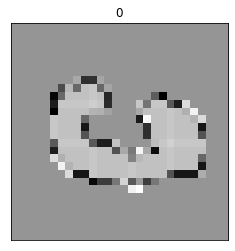

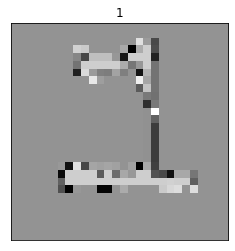

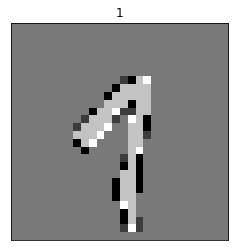

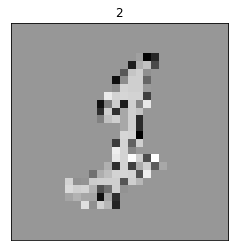

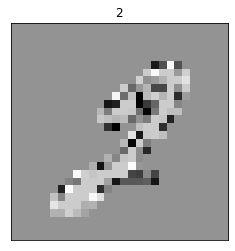

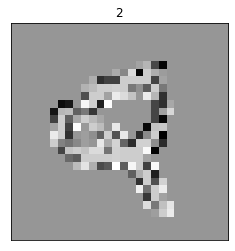

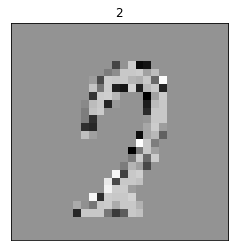

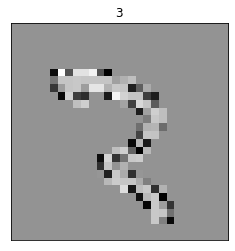

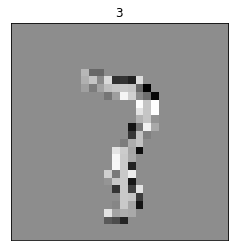

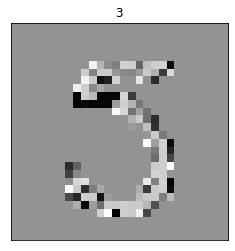

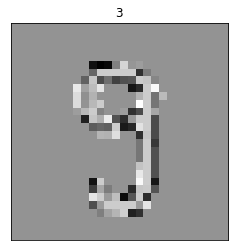

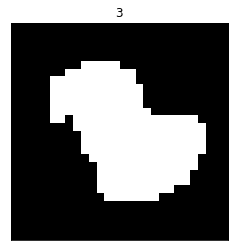

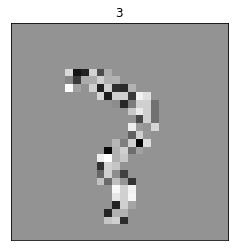

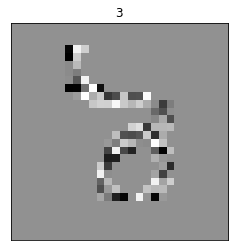

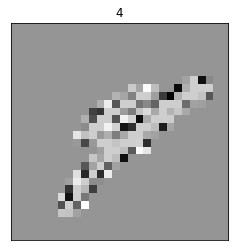

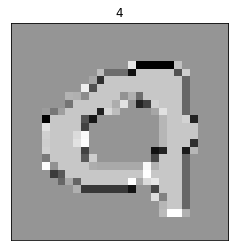

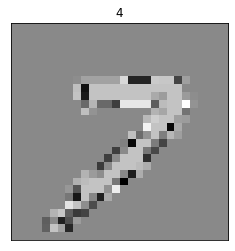

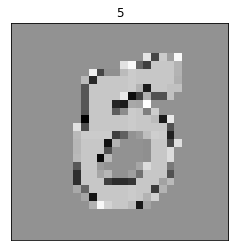

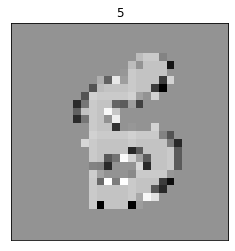

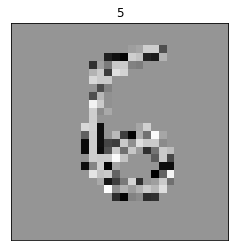

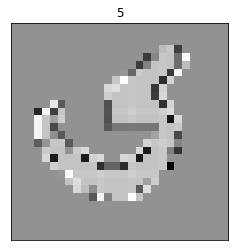

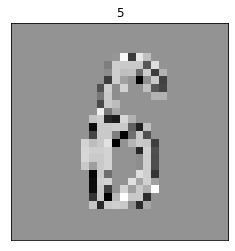

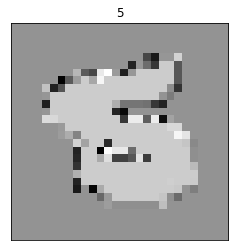

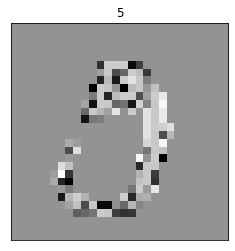

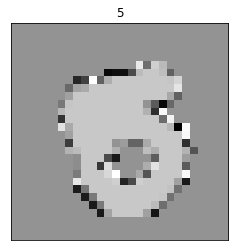

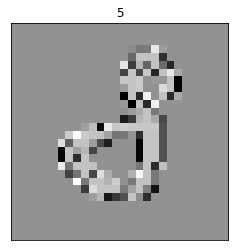

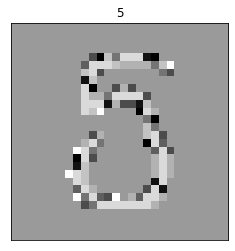

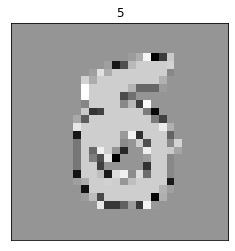

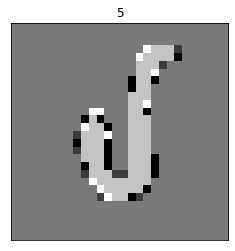

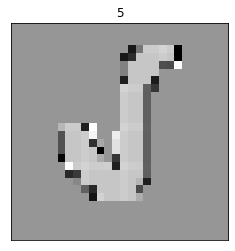

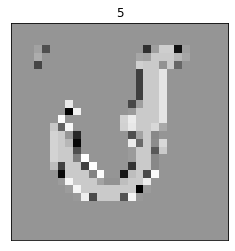

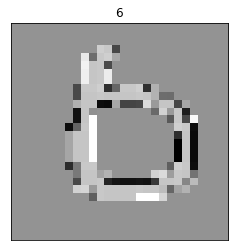

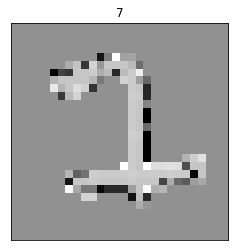

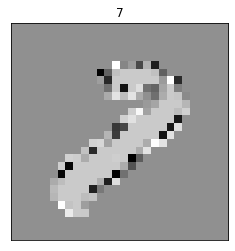

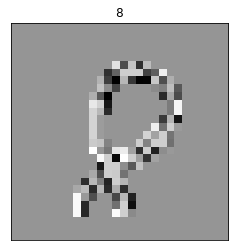

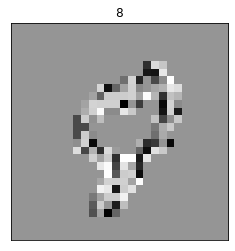

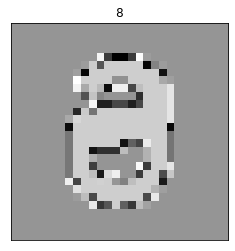

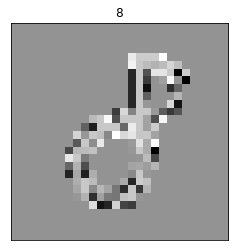

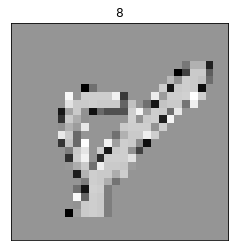

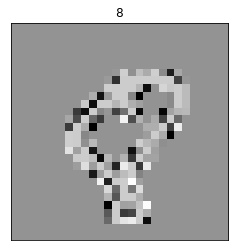

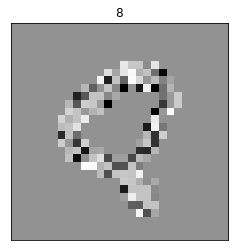

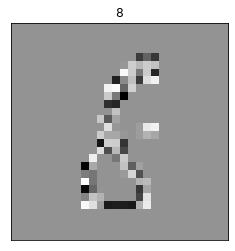

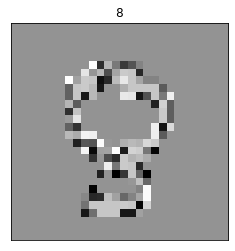

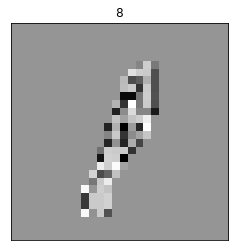

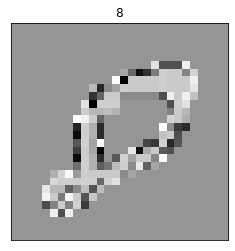

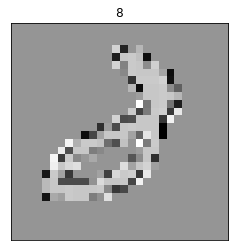

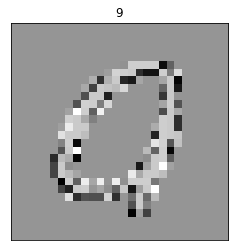

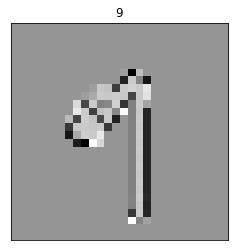

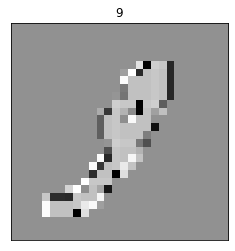

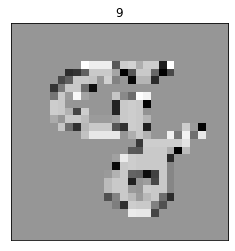

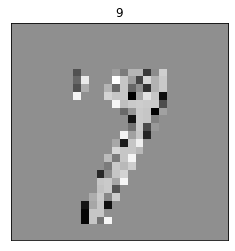

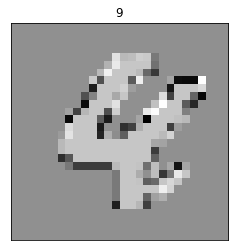

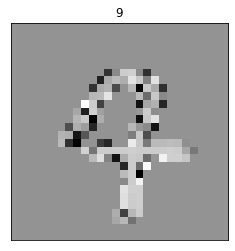

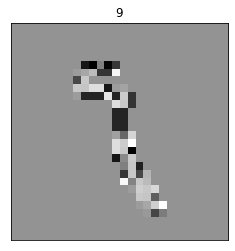

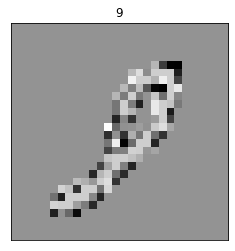

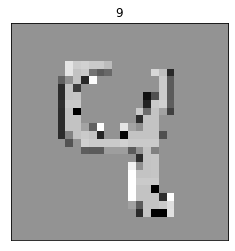

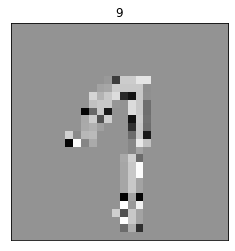

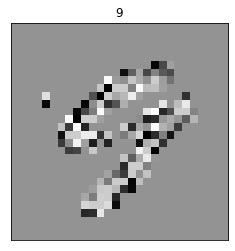

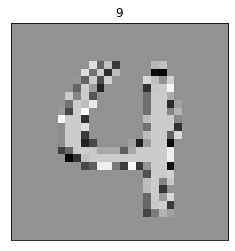

In [66]:
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers
for idx in outliers:
    img, label = dataset1[idx]
    show(img, label)